# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

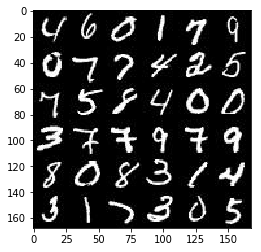

In [2]:
show_n_images = 36

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

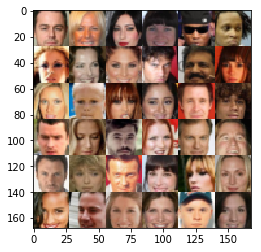

In [3]:
show_n_images = 36

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels])
    input_z = tf.placeholder(tf.float32, [None, z_dim])
    learningrate = tf.placeholder(tf.float32)
    return input_real, input_z, learningrate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/home/changkun/anaconda3/envs/RoboND/lib/python3.5/runpy.py", line 184, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/home/changkun/anaconda3/envs/RoboND/lib/python3.5/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/home/changkun/anaconda3/envs/RoboND/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/home/changkun/anaconda3/envs/RoboND/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/home/changkun/anaconda3/envs/RoboND/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 477, in start\n    ioloop.IOLoop.instance().start()', '

### Leaky ReLU
There is no LeakyReLU API in tensorflow, so it must be implemented.

In [6]:
def Leaky_ReLU(x, alpha):
    return tf.maximum(x, alpha*x)

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope("discriminator",reuse=reuse):
        alpha = 0.2
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64,5, strides=2, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 4, strides=2, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 3, strides=2, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.contrib.layers.flatten(relu3)
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator',reuse=(not is_train)):
        alpha = 0.2
        # First fully connected layer
        x1 = tf.layers.dense(z, 3*3*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 3, 3, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 3x3x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 3, strides=2, padding='valid',kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 4, strides=2, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x128 
        
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3or5 
        out = tf.tanh(logits)
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.1
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*(1-smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    vars_trainable = tf.trainable_variables()
    g_var = [v for v in vars_trainable if 'generator' in v.name]
    d_var = [v for v in vars_trainable if 'discriminator' in v.name]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        g_optmizer = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_var)
        g_optmizer = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_var)
        d_optmizer = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_var)
        
    return d_optmizer, g_optmizer


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

In [12]:
mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
batch = mnist_dataset.get_batches(64)
print('raw image range:',np.amin(next(batch)),np.amax(next(batch)))

raw image range: -0.5 0.5


### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [13]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _ , image_width, image_height, image_channels = data_shape
    input_real, input_z, learningrate = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_optmizer, g_optmizer = model_opt(d_loss, g_loss, learning_rate, beta1)

    # Plot data
    samples, losses = [], []
    steps = 0
    print_every = 50
    show_every = 500
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                
                # Get images, reshape and rescale from [-0.5,0.5]to pass to [-1,1]
                batch_images = batch_images*2
                
                steps += 1
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim)).astype(np.float32)
                #tf.random_uniform(shape=(batch_size, z_dim),minval=-1,maxval=1)
                sess.run(d_optmizer, feed_dict=
                         {input_real:batch_images, input_z:batch_z, learningrate:learning_rate})
                sess.run(g_optmizer, feed_dict=
                         {input_real:batch_images, input_z:batch_z, learningrate:learning_rate})
                
                if steps % show_every == 0:
                    show_generator_output(sess, 36, input_z, image_channels, data_image_mode)
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                              "Discriminator Loss: {:.4f}...".format(train_loss_d),
                              "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                
    import matplotlib.pyplot as plt            
    fig, ax = plt.subplots()
    losses = np.array(losses)
    plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
    plt.plot(losses.T[1], label='Generator', alpha=0.5)
    plt.title("Training Losses")
    plt.legend()

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.7055... Generator Loss: 1.8256
Epoch 1/2... Discriminator Loss: 0.9193... Generator Loss: 0.9764
Epoch 1/2... Discriminator Loss: 0.9170... Generator Loss: 1.8323
Epoch 1/2... Discriminator Loss: 0.8576... Generator Loss: 1.5253
Epoch 1/2... Discriminator Loss: 0.9869... Generator Loss: 1.3465
Epoch 1/2... Discriminator Loss: 0.8815... Generator Loss: 1.1950
Epoch 1/2... Discriminator Loss: 0.8492... Generator Loss: 1.2044
Epoch 1/2... Discriminator Loss: 0.8111... Generator Loss: 1.3677
Epoch 1/2... Discriminator Loss: 0.9299... Generator Loss: 2.3020


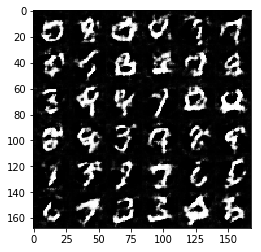

Epoch 1/2... Discriminator Loss: 0.8244... Generator Loss: 1.8272
Epoch 1/2... Discriminator Loss: 0.9304... Generator Loss: 0.9646
Epoch 1/2... Discriminator Loss: 0.7795... Generator Loss: 1.7519
Epoch 1/2... Discriminator Loss: 0.8737... Generator Loss: 1.5393
Epoch 1/2... Discriminator Loss: 0.9428... Generator Loss: 1.7838
Epoch 1/2... Discriminator Loss: 0.8344... Generator Loss: 1.2147
Epoch 1/2... Discriminator Loss: 0.9480... Generator Loss: 1.5092
Epoch 1/2... Discriminator Loss: 0.8421... Generator Loss: 1.1596
Epoch 1/2... Discriminator Loss: 0.7544... Generator Loss: 1.5975
Epoch 2/2... Discriminator Loss: 0.7943... Generator Loss: 1.4664


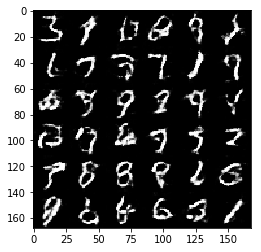

Epoch 2/2... Discriminator Loss: 0.9235... Generator Loss: 1.3595
Epoch 2/2... Discriminator Loss: 0.9374... Generator Loss: 1.1935
Epoch 2/2... Discriminator Loss: 0.6843... Generator Loss: 1.5201
Epoch 2/2... Discriminator Loss: 0.7822... Generator Loss: 1.2762
Epoch 2/2... Discriminator Loss: 0.9631... Generator Loss: 0.8924
Epoch 2/2... Discriminator Loss: 0.9933... Generator Loss: 0.9148
Epoch 2/2... Discriminator Loss: 0.8641... Generator Loss: 1.0552
Epoch 2/2... Discriminator Loss: 0.7642... Generator Loss: 1.3170
Epoch 2/2... Discriminator Loss: 1.1712... Generator Loss: 0.6652
Epoch 2/2... Discriminator Loss: 1.1612... Generator Loss: 0.6533


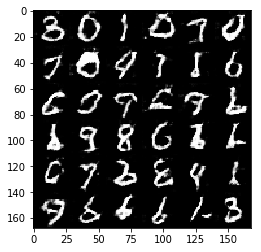

Epoch 2/2... Discriminator Loss: 0.8756... Generator Loss: 1.0151
Epoch 2/2... Discriminator Loss: 0.8388... Generator Loss: 1.7952
Epoch 2/2... Discriminator Loss: 0.9225... Generator Loss: 1.3883
Epoch 2/2... Discriminator Loss: 0.9751... Generator Loss: 0.9047
Epoch 2/2... Discriminator Loss: 1.1086... Generator Loss: 0.8263
Epoch 2/2... Discriminator Loss: 1.0072... Generator Loss: 0.7988
Epoch 2/2... Discriminator Loss: 0.8231... Generator Loss: 1.3241
Epoch 2/2... Discriminator Loss: 1.0418... Generator Loss: 0.7914


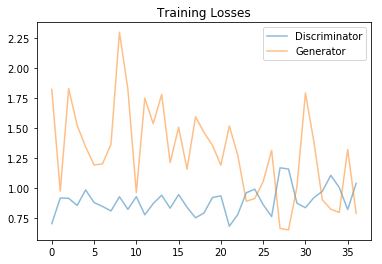

In [14]:
batch_size = 64
z_dim = 100
learning_rate = 0.0003
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/3... Discriminator Loss: 0.5045... Generator Loss: 2.4212
Epoch 1/3... Discriminator Loss: 0.9370... Generator Loss: 1.4074
Epoch 1/3... Discriminator Loss: 1.0635... Generator Loss: 0.8773
Epoch 1/3... Discriminator Loss: 1.2150... Generator Loss: 0.6950
Epoch 1/3... Discriminator Loss: 1.0750... Generator Loss: 0.8217
Epoch 1/3... Discriminator Loss: 1.1037... Generator Loss: 1.0051
Epoch 1/3... Discriminator Loss: 1.3185... Generator Loss: 1.0127
Epoch 1/3... Discriminator Loss: 1.1413... Generator Loss: 0.8176
Epoch 1/3... Discriminator Loss: 1.0841... Generator Loss: 1.1053


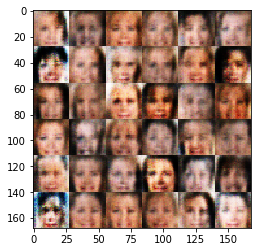

Epoch 1/3... Discriminator Loss: 1.0485... Generator Loss: 0.9068
Epoch 1/3... Discriminator Loss: 1.0786... Generator Loss: 1.0809
Epoch 1/3... Discriminator Loss: 1.1492... Generator Loss: 0.7929
Epoch 1/3... Discriminator Loss: 1.0965... Generator Loss: 1.0384
Epoch 1/3... Discriminator Loss: 1.1607... Generator Loss: 0.8595
Epoch 1/3... Discriminator Loss: 1.1271... Generator Loss: 0.8974
Epoch 1/3... Discriminator Loss: 1.0708... Generator Loss: 0.9385
Epoch 1/3... Discriminator Loss: 1.1346... Generator Loss: 1.0238
Epoch 1/3... Discriminator Loss: 1.1690... Generator Loss: 0.8638
Epoch 1/3... Discriminator Loss: 1.2547... Generator Loss: 0.9612


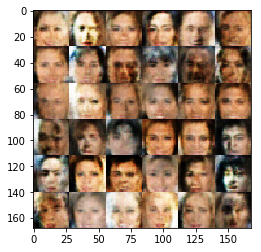

Epoch 1/3... Discriminator Loss: 1.1562... Generator Loss: 0.9532
Epoch 1/3... Discriminator Loss: 1.1103... Generator Loss: 1.1864
Epoch 1/3... Discriminator Loss: 1.1497... Generator Loss: 1.1672
Epoch 1/3... Discriminator Loss: 1.0115... Generator Loss: 1.1686
Epoch 1/3... Discriminator Loss: 1.2701... Generator Loss: 1.2520
Epoch 1/3... Discriminator Loss: 1.2563... Generator Loss: 0.7517
Epoch 1/3... Discriminator Loss: 1.2434... Generator Loss: 0.8614
Epoch 1/3... Discriminator Loss: 1.2038... Generator Loss: 1.1761
Epoch 1/3... Discriminator Loss: 1.1988... Generator Loss: 0.7974
Epoch 1/3... Discriminator Loss: 1.0438... Generator Loss: 0.8923


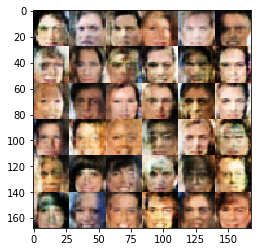

Epoch 1/3... Discriminator Loss: 1.4231... Generator Loss: 0.5024
Epoch 1/3... Discriminator Loss: 1.0322... Generator Loss: 2.2107
Epoch 1/3... Discriminator Loss: 1.0708... Generator Loss: 1.0164
Epoch 1/3... Discriminator Loss: 1.0506... Generator Loss: 1.4655
Epoch 1/3... Discriminator Loss: 1.1159... Generator Loss: 1.0540
Epoch 1/3... Discriminator Loss: 1.1862... Generator Loss: 0.8090
Epoch 1/3... Discriminator Loss: 1.1612... Generator Loss: 1.4706
Epoch 1/3... Discriminator Loss: 1.1048... Generator Loss: 0.8207
Epoch 1/3... Discriminator Loss: 1.2012... Generator Loss: 0.7158
Epoch 1/3... Discriminator Loss: 0.9489... Generator Loss: 1.2722


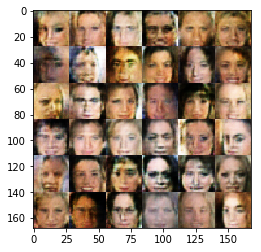

Epoch 1/3... Discriminator Loss: 0.9491... Generator Loss: 1.1086
Epoch 1/3... Discriminator Loss: 1.0708... Generator Loss: 0.8795
Epoch 1/3... Discriminator Loss: 1.2296... Generator Loss: 0.7493
Epoch 1/3... Discriminator Loss: 1.3178... Generator Loss: 0.5604
Epoch 1/3... Discriminator Loss: 1.0035... Generator Loss: 1.0264
Epoch 1/3... Discriminator Loss: 1.2540... Generator Loss: 0.6682
Epoch 1/3... Discriminator Loss: 1.1396... Generator Loss: 0.8127
Epoch 1/3... Discriminator Loss: 1.0483... Generator Loss: 0.8732
Epoch 1/3... Discriminator Loss: 1.1456... Generator Loss: 0.7651
Epoch 1/3... Discriminator Loss: 1.2925... Generator Loss: 0.6245


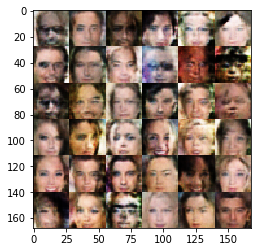

Epoch 1/3... Discriminator Loss: 1.3638... Generator Loss: 0.6904
Epoch 1/3... Discriminator Loss: 0.8429... Generator Loss: 1.3994
Epoch 1/3... Discriminator Loss: 0.9522... Generator Loss: 1.3213
Epoch 1/3... Discriminator Loss: 1.1974... Generator Loss: 0.7914
Epoch 1/3... Discriminator Loss: 1.0121... Generator Loss: 1.3335
Epoch 1/3... Discriminator Loss: 1.1501... Generator Loss: 0.8554
Epoch 1/3... Discriminator Loss: 1.2923... Generator Loss: 0.6447
Epoch 1/3... Discriminator Loss: 1.1025... Generator Loss: 1.1897
Epoch 1/3... Discriminator Loss: 0.9891... Generator Loss: 1.2378
Epoch 1/3... Discriminator Loss: 1.1625... Generator Loss: 1.4575


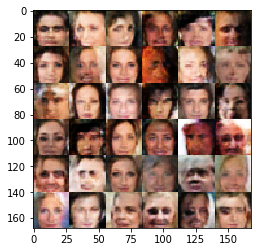

Epoch 1/3... Discriminator Loss: 1.2048... Generator Loss: 0.9115
Epoch 1/3... Discriminator Loss: 1.1114... Generator Loss: 0.9392
Epoch 1/3... Discriminator Loss: 1.1085... Generator Loss: 0.9864
Epoch 1/3... Discriminator Loss: 1.4288... Generator Loss: 0.5208
Epoch 2/3... Discriminator Loss: 1.0673... Generator Loss: 0.8727
Epoch 2/3... Discriminator Loss: 0.9557... Generator Loss: 1.3864
Epoch 2/3... Discriminator Loss: 1.3388... Generator Loss: 0.6270
Epoch 2/3... Discriminator Loss: 1.1186... Generator Loss: 0.8980
Epoch 2/3... Discriminator Loss: 1.1013... Generator Loss: 0.8686
Epoch 2/3... Discriminator Loss: 1.0804... Generator Loss: 0.8886


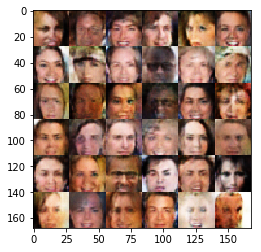

Epoch 2/3... Discriminator Loss: 1.0635... Generator Loss: 0.9078
Epoch 2/3... Discriminator Loss: 1.0328... Generator Loss: 0.9481
Epoch 2/3... Discriminator Loss: 1.2050... Generator Loss: 0.6641
Epoch 2/3... Discriminator Loss: 1.2224... Generator Loss: 0.6786
Epoch 2/3... Discriminator Loss: 1.2345... Generator Loss: 0.6203
Epoch 2/3... Discriminator Loss: 1.0565... Generator Loss: 1.0722
Epoch 2/3... Discriminator Loss: 1.3138... Generator Loss: 0.6239
Epoch 2/3... Discriminator Loss: 1.0109... Generator Loss: 1.0057
Epoch 2/3... Discriminator Loss: 1.3882... Generator Loss: 0.5826
Epoch 2/3... Discriminator Loss: 1.0381... Generator Loss: 1.0138


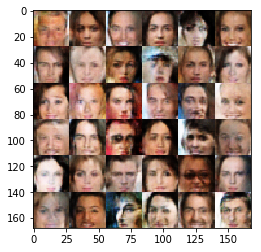

Epoch 2/3... Discriminator Loss: 1.3571... Generator Loss: 1.0835
Epoch 2/3... Discriminator Loss: 1.0759... Generator Loss: 0.9492
Epoch 2/3... Discriminator Loss: 1.2067... Generator Loss: 1.0119
Epoch 2/3... Discriminator Loss: 1.2754... Generator Loss: 0.6537
Epoch 2/3... Discriminator Loss: 1.0912... Generator Loss: 0.9226
Epoch 2/3... Discriminator Loss: 1.2766... Generator Loss: 0.7620
Epoch 2/3... Discriminator Loss: 1.2729... Generator Loss: 0.6281
Epoch 2/3... Discriminator Loss: 1.3138... Generator Loss: 1.1702
Epoch 2/3... Discriminator Loss: 1.0934... Generator Loss: 1.1518
Epoch 2/3... Discriminator Loss: 0.9760... Generator Loss: 1.1000


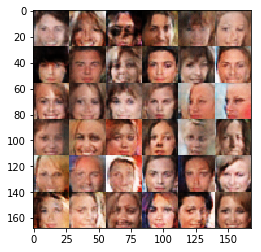

Epoch 2/3... Discriminator Loss: 1.1795... Generator Loss: 0.7583
Epoch 2/3... Discriminator Loss: 1.2898... Generator Loss: 1.0094
Epoch 2/3... Discriminator Loss: 1.1495... Generator Loss: 1.2674
Epoch 2/3... Discriminator Loss: 1.1481... Generator Loss: 1.1144
Epoch 2/3... Discriminator Loss: 1.6509... Generator Loss: 0.4359
Epoch 2/3... Discriminator Loss: 1.1843... Generator Loss: 0.8428
Epoch 2/3... Discriminator Loss: 1.2545... Generator Loss: 0.6872
Epoch 2/3... Discriminator Loss: 0.9574... Generator Loss: 1.2873
Epoch 2/3... Discriminator Loss: 1.2217... Generator Loss: 0.8738
Epoch 2/3... Discriminator Loss: 1.0481... Generator Loss: 1.0097


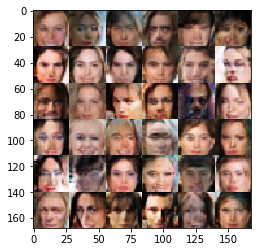

Epoch 2/3... Discriminator Loss: 1.3159... Generator Loss: 0.6681
Epoch 2/3... Discriminator Loss: 1.2858... Generator Loss: 0.6286
Epoch 2/3... Discriminator Loss: 1.0471... Generator Loss: 1.3372
Epoch 2/3... Discriminator Loss: 1.3380... Generator Loss: 0.5785
Epoch 2/3... Discriminator Loss: 1.1672... Generator Loss: 0.8417
Epoch 2/3... Discriminator Loss: 1.0689... Generator Loss: 0.9409
Epoch 2/3... Discriminator Loss: 1.4744... Generator Loss: 0.5033
Epoch 2/3... Discriminator Loss: 1.2014... Generator Loss: 0.7773
Epoch 2/3... Discriminator Loss: 1.2709... Generator Loss: 0.6324
Epoch 2/3... Discriminator Loss: 1.1905... Generator Loss: 0.7042


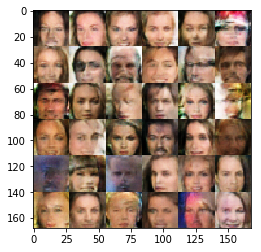

Epoch 2/3... Discriminator Loss: 1.1127... Generator Loss: 0.8914
Epoch 2/3... Discriminator Loss: 1.0255... Generator Loss: 0.9463
Epoch 2/3... Discriminator Loss: 1.2571... Generator Loss: 0.7442
Epoch 2/3... Discriminator Loss: 1.2856... Generator Loss: 1.1366
Epoch 2/3... Discriminator Loss: 1.1983... Generator Loss: 0.8412
Epoch 2/3... Discriminator Loss: 1.2031... Generator Loss: 0.7119
Epoch 2/3... Discriminator Loss: 1.1556... Generator Loss: 0.9054
Epoch 2/3... Discriminator Loss: 1.2308... Generator Loss: 0.7411
Epoch 2/3... Discriminator Loss: 1.2441... Generator Loss: 0.6490
Epoch 2/3... Discriminator Loss: 1.1960... Generator Loss: 0.8446


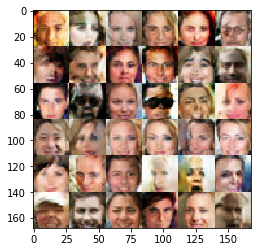

Epoch 2/3... Discriminator Loss: 1.3491... Generator Loss: 0.9868
Epoch 2/3... Discriminator Loss: 1.2555... Generator Loss: 0.6675
Epoch 2/3... Discriminator Loss: 1.3585... Generator Loss: 0.8152
Epoch 2/3... Discriminator Loss: 1.1272... Generator Loss: 1.0148
Epoch 2/3... Discriminator Loss: 1.2163... Generator Loss: 1.1869
Epoch 2/3... Discriminator Loss: 1.2132... Generator Loss: 0.8007
Epoch 2/3... Discriminator Loss: 1.2829... Generator Loss: 0.8250
Epoch 3/3... Discriminator Loss: 1.1963... Generator Loss: 0.8124
Epoch 3/3... Discriminator Loss: 1.1672... Generator Loss: 0.9253
Epoch 3/3... Discriminator Loss: 1.3206... Generator Loss: 1.7613


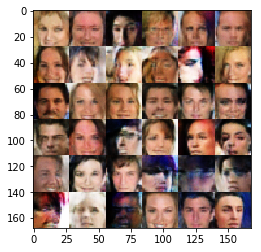

Epoch 3/3... Discriminator Loss: 1.1956... Generator Loss: 0.8426
Epoch 3/3... Discriminator Loss: 0.9163... Generator Loss: 1.2120
Epoch 3/3... Discriminator Loss: 1.3513... Generator Loss: 1.1171
Epoch 3/3... Discriminator Loss: 1.4024... Generator Loss: 0.7282
Epoch 3/3... Discriminator Loss: 1.1651... Generator Loss: 0.9204
Epoch 3/3... Discriminator Loss: 1.0824... Generator Loss: 0.9262
Epoch 3/3... Discriminator Loss: 1.2894... Generator Loss: 0.7733
Epoch 3/3... Discriminator Loss: 1.3436... Generator Loss: 0.6249
Epoch 3/3... Discriminator Loss: 1.3160... Generator Loss: 0.5920
Epoch 3/3... Discriminator Loss: 1.0534... Generator Loss: 0.8156


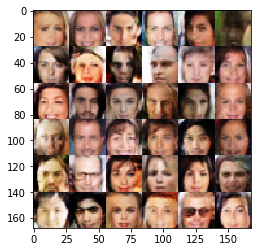

Epoch 3/3... Discriminator Loss: 1.3595... Generator Loss: 1.1127
Epoch 3/3... Discriminator Loss: 1.1207... Generator Loss: 0.9359
Epoch 3/3... Discriminator Loss: 1.1506... Generator Loss: 0.8627
Epoch 3/3... Discriminator Loss: 1.1599... Generator Loss: 1.0361
Epoch 3/3... Discriminator Loss: 1.6748... Generator Loss: 0.6374
Epoch 3/3... Discriminator Loss: 1.1925... Generator Loss: 0.9112
Epoch 3/3... Discriminator Loss: 1.2707... Generator Loss: 0.7554
Epoch 3/3... Discriminator Loss: 1.1652... Generator Loss: 0.8310
Epoch 3/3... Discriminator Loss: 1.1012... Generator Loss: 0.9250
Epoch 3/3... Discriminator Loss: 1.1049... Generator Loss: 0.9229


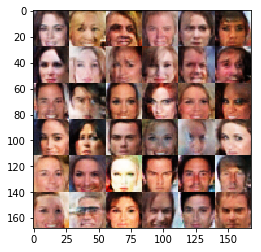

Epoch 3/3... Discriminator Loss: 1.0716... Generator Loss: 1.0590
Epoch 3/3... Discriminator Loss: 1.4697... Generator Loss: 0.5621
Epoch 3/3... Discriminator Loss: 1.0601... Generator Loss: 0.8780
Epoch 3/3... Discriminator Loss: 1.0350... Generator Loss: 1.0611
Epoch 3/3... Discriminator Loss: 1.1581... Generator Loss: 1.0014
Epoch 3/3... Discriminator Loss: 1.1617... Generator Loss: 0.9994
Epoch 3/3... Discriminator Loss: 1.4828... Generator Loss: 0.6057
Epoch 3/3... Discriminator Loss: 1.2093... Generator Loss: 1.1730
Epoch 3/3... Discriminator Loss: 1.2466... Generator Loss: 0.7869
Epoch 3/3... Discriminator Loss: 1.1568... Generator Loss: 0.9274


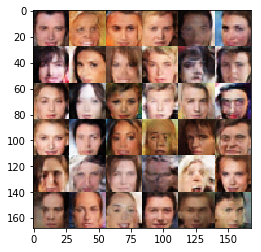

Epoch 3/3... Discriminator Loss: 1.1167... Generator Loss: 0.9325
Epoch 3/3... Discriminator Loss: 0.8933... Generator Loss: 1.4582
Epoch 3/3... Discriminator Loss: 1.3801... Generator Loss: 0.5803
Epoch 3/3... Discriminator Loss: 1.3637... Generator Loss: 0.5627
Epoch 3/3... Discriminator Loss: 1.1242... Generator Loss: 0.8529
Epoch 3/3... Discriminator Loss: 1.2695... Generator Loss: 0.6916
Epoch 3/3... Discriminator Loss: 1.1933... Generator Loss: 0.8824
Epoch 3/3... Discriminator Loss: 1.1159... Generator Loss: 0.9045
Epoch 3/3... Discriminator Loss: 1.5861... Generator Loss: 0.4387
Epoch 3/3... Discriminator Loss: 1.2732... Generator Loss: 1.0070


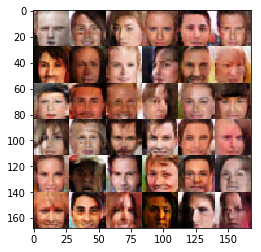

Epoch 3/3... Discriminator Loss: 1.1020... Generator Loss: 0.9877
Epoch 3/3... Discriminator Loss: 1.3168... Generator Loss: 0.6436
Epoch 3/3... Discriminator Loss: 1.3171... Generator Loss: 0.8964
Epoch 3/3... Discriminator Loss: 1.3441... Generator Loss: 0.6826
Epoch 3/3... Discriminator Loss: 1.4180... Generator Loss: 0.5128
Epoch 3/3... Discriminator Loss: 1.1929... Generator Loss: 0.9827
Epoch 3/3... Discriminator Loss: 1.1779... Generator Loss: 0.7933
Epoch 3/3... Discriminator Loss: 1.1439... Generator Loss: 0.9698
Epoch 3/3... Discriminator Loss: 1.1135... Generator Loss: 0.9374
Epoch 3/3... Discriminator Loss: 1.3034... Generator Loss: 0.6437


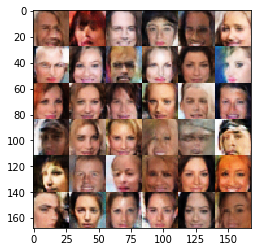

Epoch 3/3... Discriminator Loss: 1.0915... Generator Loss: 1.0085
Epoch 3/3... Discriminator Loss: 1.3179... Generator Loss: 0.9230
Epoch 3/3... Discriminator Loss: 1.3822... Generator Loss: 0.7774
Epoch 3/3... Discriminator Loss: 1.2287... Generator Loss: 0.7912
Epoch 3/3... Discriminator Loss: 1.2933... Generator Loss: 0.6611
Epoch 3/3... Discriminator Loss: 1.1957... Generator Loss: 0.8248
Epoch 3/3... Discriminator Loss: 0.9992... Generator Loss: 1.1118
Epoch 3/3... Discriminator Loss: 1.1702... Generator Loss: 0.9156
Epoch 3/3... Discriminator Loss: 1.1414... Generator Loss: 0.9373
Epoch 3/3... Discriminator Loss: 1.1707... Generator Loss: 0.9776


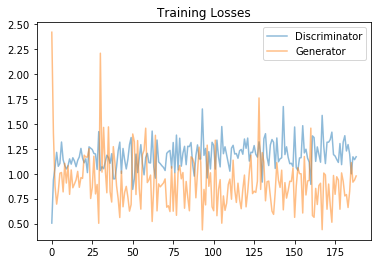

In [15]:
batch_size = 64
z_dim = 100
learning_rate = 0.0003
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 3

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.